### Objective



In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import ast
import tqdm
import pathlib
import pydicom
import PIL
import cv2
import warnings
import logging
import re
import seaborn as sn
import zipfile
import pandas as pd
from joblib import Parallel, delayed

In [2]:
os.getcwd()

'C:\\Users\\prans\\Python files\\Kaggle Competitions\\Covid_19_object_detection'

In [3]:
PATH = pathlib.Path('D:\Datasets')

In [4]:
#unzip = zipfile.ZipFile(os.path.join(PATH, 'siim-covid19-detection.zip'))

In [5]:
DATA_PATH = os.path.join(PATH,'siim_covid19_detection')

In [6]:
#unzip.extractall(path= DATA_PATH)

In [7]:
data_dir = pathlib.Path(DATA_PATH)

In [8]:
list(data_dir.glob('*'))

[WindowsPath('D:/Datasets/siim_covid19_detection/1080px'),
 WindowsPath('D:/Datasets/siim_covid19_detection/320px'),
 WindowsPath('D:/Datasets/siim_covid19_detection/512px'),
 WindowsPath('D:/Datasets/siim_covid19_detection/512px_variable'),
 WindowsPath('D:/Datasets/siim_covid19_detection/600px'),
 WindowsPath('D:/Datasets/siim_covid19_detection/sample_submission.csv'),
 WindowsPath('D:/Datasets/siim_covid19_detection/study.csv'),
 WindowsPath('D:/Datasets/siim_covid19_detection/test'),
 WindowsPath('D:/Datasets/siim_covid19_detection/train'),
 WindowsPath('D:/Datasets/siim_covid19_detection/train_final.csv'),
 WindowsPath('D:/Datasets/siim_covid19_detection/train_image_level.csv'),
 WindowsPath('D:/Datasets/siim_covid19_detection/train_study_level.csv')]

In [9]:
train_dir = pathlib.Path(os.path.join(data_dir, 'train'))
test_dir = pathlib.Path(os.path.join(data_dir, 'test'))
train_image_level_path = pathlib.Path(os.path.join(data_dir, 'train_image_level.csv'))
train_study_level_path = pathlib.Path(os.path.join(data_dir, 'train_study_level.csv'))

In [10]:
train_image_df = pd.read_csv(train_image_level_path)
train_study_df = pd.read_csv(train_study_level_path)

In [11]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [12]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [13]:
train_image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


In [14]:
train_study_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [15]:
# Storing all the file names
train_image_paths = list(train_dir.glob('*/*/*.dcm'))
test_image_paths = list(test_dir.glob('*/*/*.dcm'))

In [16]:
print(f'Number of images in \nTRAIN: {len(train_image_paths)}\nTEST: {len(test_image_paths)}')

Number of images in 
TRAIN: 6334
TEST: 1263


In [17]:
# Reading a sample scan 
train_sample = pydicom.dcmread(train_image_paths[0])
test_sample = pydicom.dcmread(test_image_paths[0])

In [18]:
train_sample_image = train_sample.pixel_array
test_sample_image = test_sample.pixel_array


 <div class = 'alert alert-info'>Note: The images will have to reshaped to add the third dimension</div>

In [19]:
print(f'Train image: {train_sample_image.shape}, Test image: {test_sample_image.shape}')

Train image: (2330, 2783), Test image: (3480, 4248)


<div style = 'color: #ad0350'>Image sizes are not uniform</div>

In [20]:
print(f'TRAIN_IMAGE - Min Pixel value: {np.min(train_sample_image)}, Max Pixel Value: {np.max(train_sample_image)}')
print(f'TEST_IMAGE - Min Pixel value: {np.min(test_sample_image)}, Max Pixel Value: {np.max(test_sample_image)}')

TRAIN_IMAGE - Min Pixel value: 0, Max Pixel Value: 3775
TEST_IMAGE - Min Pixel value: 0, Max Pixel Value: 255


In [21]:
print(f'Train image dtype: {train_sample_image.dtype}, Test image dtype: {test_sample_image.dtype}')

Train image dtype: uint16, Test image dtype: uint8


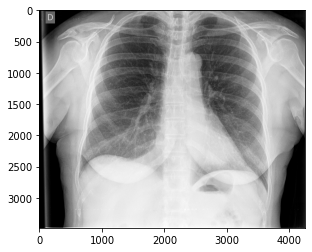

In [22]:
plt.imshow(test_sample_image, cmap = 'gray')

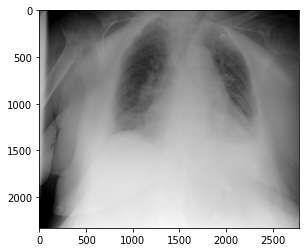

In [23]:
plt.imshow(train_sample_image, cmap = 'gray')

In [24]:
# Number of unique study level records
train_image_df.StudyInstanceUID.nunique()

6054

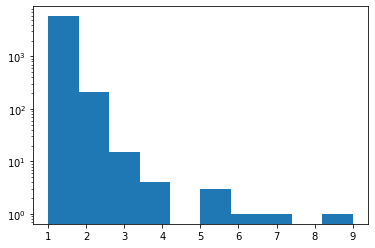

In [25]:
plt.hist(train_image_df["StudyInstanceUID"].value_counts())
plt.yscale('log')

In [26]:
train_image_df['StudyInstanceUID'].value_counts()[:10]

0fd2db233deb    9
a7335b2f9815    7
8943d1d85097    6
a0254bf8a96e    5
970c96c9fa5d    5
a4e94133d95a    5
c39d68397d84    4
74ba8f2badcb    4
7e91e041c7d4    4
79c3bf957d49    4
Name: StudyInstanceUID, dtype: int64

<div style = 'color: #ad0350'>There are some patients with more than one image record. </div>

In [27]:
train_image_df[train_image_df['StudyInstanceUID'] == train_image_df['StudyInstanceUID'].value_counts().index[0]]

,id,boxes,label,StudyInstanceUID
130,04cc2f7f4c4b_image,NaN,none 1 0 0 1 1,0fd2db233deb
156,05c063f5cef5_image,NaN,none 1 0 0 1 1,0fd2db233deb
551,156cb1f5c689_image,NaN,none 1 0 0 1 1,0fd2db233deb
964,26f643772090_image,"[{'x': 561.30269, 'y': 163.28797, 'width': 883...",opacity 1 561.30269 163.28797 1445.02377 1495....,0fd2db233deb
1861,4c414b793562_image,NaN,none 1 0 0 1 1,0fd2db233deb
4044,a5a364383f34_image,NaN,none 1 0 0 1 1,0fd2db233deb
4340,b121806162c3_image,NaN,none 1 0 0 1 1,0fd2db233deb
4698,bee62c601ae9_image,NaN,none 1 0 0 1 1,0fd2db233deb
4902,c6e92e59a0ae_image,NaN,none 1 0 0 1 1,0fd2db233deb


In [28]:
train_study_df.sum(axis = 1)

0       1
1       1
2       1
3       1
4       1
       ..
6049    1
6050    1
6051    1
6052    1
6053    1
Length: 6054, dtype: int64

<div style = 'color: #ad0350'>Only one class has been assigned for each study level classification. Although an image may have more than one class assigned to it (as mentioned in competition guidelines)</div>

In [29]:
train_image_df['StudyInstanceUID'] = train_image_df['StudyInstanceUID']+ '_study'

In [30]:
train_df = train_image_df.merge(train_study_df, left_on = 'StudyInstanceUID', right_on = 'id',)

In [31]:
train_df.drop(columns = ['id_y'], inplace = True)

In [32]:
train_df.head()

,id_x,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75_study,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed_study,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7_study,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2_study,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e_study,0,1,0,0


In [33]:
train_df[train_df['StudyInstanceUID'] == train_df['StudyInstanceUID'].value_counts().index[8]]

,id_x,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1604,3cde0ddf01c7_image,NaN,none 1 0 0 1 1,7e91e041c7d4_study,0,0,1,0
1605,cf0cdff4ef2e_image,NaN,none 1 0 0 1 1,7e91e041c7d4_study,0,0,1,0
1606,d3885c0f58bb_image,"[{'x': 203.04027, 'y': 529.5972, 'width': 600....",opacity 1 203.04027 529.5972 803.25041 1628.51...,7e91e041c7d4_study,0,0,1,0
1607,e7e072c73e1d_image,NaN,none 1 0 0 1 1,7e91e041c7d4_study,0,0,1,0


#### Visualizing a chest x ray with the bounding boxes drawn

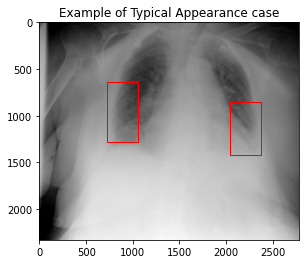

In [35]:
import matplotlib.patches as patches

train_sample_row = train_df[train_df['StudyInstanceUID'] == train_sample.StudyInstanceUID + '_study']
bboxes = ast.literal_eval(train_sample_row['boxes'].values[0])
class_name = [i  for i in train_sample_row.columns[-4:] if train_sample_row[i].values[0] == 1][0]
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(train_sample_image, cmap ='gray')
for i in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((i['x'], i['y']), i['width'], i['height'], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
plt.title(f'Example of {class_name} case', fontsize = 12)
plt.show()

#### Distribution of study level labels in the dataset

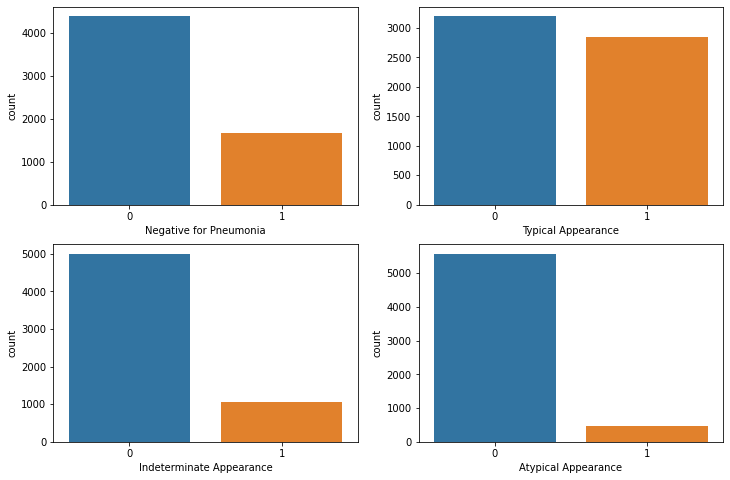

In [37]:
plt.figure(figsize = (12,8))
for i, label in enumerate(train_study_df.columns[1:]):
    
    plt.subplot(2,2,i+1)
    sn.countplot(x = train_study_df[label])
plt.show()

<div style = 'color: #ad0350'>The class labels are imbalanced with 'Typical Appearance' label comprising approximately half of the train dataset and 'Atypical Appearance' label occupying a very small proportion of the dataset. We can use data augmentation techniques to increase the percentage of latter class label images.</div>

In [38]:
train_df['boxes'] = train_df['boxes'].apply(lambda x: ast.literal_eval(x) if x is not np.nan else x)

In [39]:
train_df['label class'] = train_df['label'].str.split(' ',expand = True).iloc[:,0]

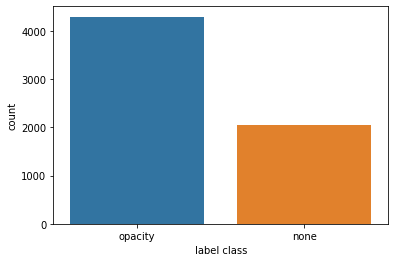

In [40]:
sn.countplot(x = train_df['label class'])
plt.show()

<div style = 'color:#ad0350'>Nearly 2000 of the images have no bounding boxes i.e. there is no appearance of any type of infection in the X-ray. This figure is greater than the number of 'Negative for Pneumonia' study level class label as their are studies that contain multiple images out of which only few have covid-19 detected.</div>

In [41]:
# Exact number of patient studies with negative label for covid-19
train_df.loc[(train_df['label class'] == 'none') & (train_df['Negative for Pneumonia'] == 1)].shape[0]

1736

In [42]:
# rows, columns = [],[]
# for file in train_image_paths:
#     img = pydicom.read_file(file)
#     rows.append(img.Rows)
#     columns.append(img.Columns)
# train_df['rows'] = rows
# train_df['columns'] = columns

In [43]:
train_df.head()

,id_x,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,label class
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75_study,0,1,0,0,opacity
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed_study,1,0,0,0,none
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7_study,0,1,0,0,opacity
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2_study,0,0,0,1,opacity
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e_study,0,1,0,0,opacity


In [44]:
train_df['id_x'] = train_df['id_x'].apply(lambda x: x.split('_')[0])

In [45]:
train_df.rename(columns = {'id_x': 'id'}, inplace= True)

In [46]:
# Saving the csv file 
train_df.to_csv(os.path.join(DATA_PATH, 'train_final.csv'),index = False)

In [47]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_final.csv'),index_col='id' )

In [48]:
train_df.head()

,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,label class
id,,,,,,,,
000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75_study,0,1,0,0,opacity
000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed_study,1,0,0,0,none
0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7_study,0,1,0,0,opacity
001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2_study,0,0,0,1,opacity
001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e_study,0,1,0,0,opacity


In [49]:
meta_df = pd.DataFrame(index=train_df.index)
meta_df.loc[:, 'rows'] = -1
meta_df.loc[:, 'columns'] = -1

In [50]:
def get_meta(path):
    file_name = str(path).split(os.sep)[-1]
    image_id = file_name.split('.')[0]
    image = pydicom.dcmread(path)
    meta_df.loc[image_id, 'rows'] = image.Rows
    meta_df.loc[image_id, 'columns'] = image.Columns

In [52]:
# for path in tqdm.tqdm(train_image_paths):
#     get_meta(path)

In [ ]:
train_df = train_df.merge(meta_df, left_index = True, right_index = True)

In [81]:
train_study_df

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [99]:
multi_image_studies_df = pd.DataFrame(train_df['StudyInstanceUID'].value_counts() > 1).rename(columns = {'StudyInstanceUID': 'Multi_image_bool'})

In [109]:
train_df = train_df.merge(multi_image_studies_df, left_on = 'StudyInstanceUID', right_index = True)

In [136]:
study_df = train_df[~((train_df['label class'] == 'none') & (train_df['Multi_image_bool'] == True))]

In [138]:
study_df.to_csv(os.path.join(DATA_PATH, 'study.csv'))